# Installs

In [ ]:
%pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchtext==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117 -q


This may take a while

In [ ]:
!pip install wandb --quiet
!pip install python-Levenshtein -q
!git clone --recursive https://github.com/parlance/ctcdecode.git
!pip install wget -q
%cd ctcdecode
!pip install . -q
%cd ..

!pip install torchsummaryX -q

fatal: destination path 'ctcdecode' already exists and is not an empty directory.
/content/ctcdecode
  Preparing metadata (setup.py) ... done
/content


In [ ]:
'''
If torchsummaryX doesn't work, please run this cell. Alternatively, please refer to Piazza post @209 for more assistance:
'''

!pip install torchsummaryX==1.3.0

# Imports

In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.nn.utils.rnn import PackedSequence
import torchaudio.transforms as tat
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
import gc

import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime

# imports for decoding and distance calculation
import ctcdecode
import Levenshtein
from ctcdecode import CTCBeamDecoder

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


# Kaggle Setup

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8 -q
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"","key":""}') # TODO: Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!kaggle competitions download -c hw3p2asr-s24

100% 3.73G/3.74G [00:36<00:00, 106MB/s]
100% 3.74G/3.74G [00:36<00:00, 110MB/s]


In [ ]:
'''
This will take a couple minutes, but you should see at least the following:
11-785-s24-hw3p2  ctcdecode  hw3p2asr-s24.zip  sample_data
'''
!unzip -q hw3p2asr-s24.zip
!ls

11-785-s24-hw3p2  ctcdecode  hw3p2asr-s24.zip  sample_data


# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Dataset and Dataloader

In [ ]:
# ARPABET PHONEME MAPPING
# DO NOT CHANGE

CMUdict_ARPAbet = {
    "" : " ",
    "[SIL]": "-", "NG": "G", "F" : "f", "M" : "m", "AE": "@",
    "R"    : "r", "UW": "u", "N" : "n", "IY": "i", "AW": "W",
    "V"    : "v", "UH": "U", "OW": "o", "AA": "a", "ER": "R",
    "HH"   : "h", "Z" : "z", "K" : "k", "CH": "C", "W" : "w",
    "EY"   : "e", "ZH": "Z", "T" : "t", "EH": "E", "Y" : "y",
    "AH"   : "A", "B" : "b", "P" : "p", "TH": "T", "DH": "D",
    "AO"   : "c", "G" : "g", "L" : "l", "JH": "j", "OY": "O",
    "SH"   : "S", "D" : "d", "AY": "Y", "S" : "s", "IH": "I",
    "[SOS]": "[SOS]", "[EOS]": "[EOS]"
}

CMUdict = list(CMUdict_ARPAbet.keys())
ARPAbet = list(CMUdict_ARPAbet.values())


PHONEMES = CMUdict[:-2]
LABELS = ARPAbet[:-2]

In [ ]:
# You might want to play around with the mapping as a sanity check here
import os
files = os.listdir('../content/11-785-s24-hw3p2/dev-clean/mfcc')
print(f'{len(files)}')

2703


In [ ]:
mfcc = '../content/11-785-s24-hw3p2/dev-clean/mfcc/' + files[1]
tran = '../content/11-785-s24-hw3p2/dev-clean/transcript/' + files[1]
vect = np.load(mfcc)
dat_pad = np.pad(vect, ((5, 5), (0, 0)), mode='constant', constant_values=0)
print(dat_pad[-5:].flatten().shape)
print(vect.shape)
trans = np.load(tran)
print(np.where(np.array(PHONEMES) == 'UH')[0])
print(f'Length of labels {len(trans)} and {trans}')

(135,)
(915, 27)
[12]
Length of labels 119 and ['[SOS]' '[SIL]' 'AE' 'T' 'AH' 'N' 'AH' 'DH' 'ER' 'T' 'AY' 'M' 'W' 'EH'
 'N' 'AY' 'W' 'AA' 'Z' 'F' 'AO' 'R' 'T' 'IY' 'N' 'Y' 'IH' 'R' 'Z' 'OW' 'L'
 'D' 'W' 'IY' 'HH' 'AE' 'D' 'JH' 'AH' 'S' 'T' 'L' 'EH' 'F' 'T' 'F' 'AO'
 'R' 'T' 'EH' 'L' 'IH' 'S' 'AA' 'N' 'DH' 'AH' 'S' 'IH' 'N' 'AH' 'B' 'AW'
 'N' 'R' 'IH' 'V' 'ER' '[SIL]' 'AH' 'N' 'D' 'M' 'AY' 'Y' 'AH' 'NG' 'G'
 'AH' 'S' 'T' 'AH' 'NG' 'K' 'AH' 'L' 'HH' 'AE' 'D' 'S' 'AH' 'L' 'EH' 'K'
 'T' 'AH' 'D' 'AH' 'F' 'AY' 'N' 'S' 'P' 'AA' 'T' 'F' 'AO' 'R' 'AW' 'ER'
 'N' 'AY' 'T' 'K' 'AE' 'M' 'P' '[SIL]' '[EOS]']


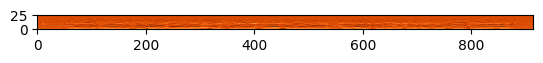

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
mfcc_data= np.swapaxes(vect, 0 ,1)
cax = plt.imshow(mfcc_data, interpolation='nearest', cmap=cm.Oranges_r, origin='lower')
plt.show()

In [ ]:
mfcc = vect
print(vect.shape)
mfcc = ((mfcc) - (np.mean(mfcc, axis=0))) / (np.sqrt(np.var(mfcc, axis=0)))
print(mfcc.shape)
concat = np.concatenate(mfcc, axis=0)
print(concat.shape)

(915, 27)
(915, 27)
(24705,)


### Train Data

In [ ]:
class AudioDataset(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self, root, phonemes = PHONEMES, partition= "train-clean-100"):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them

        self.mfcc_dir = os.path.join(root, partition, 'mfcc')
        self.transcript_dir = os.path.join(root, partition, 'transcript')

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.transcript_files = sorted(os.listdir(self.transcript_dir))

        self.PHONEMES = PHONEMES

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        assert len(self.mfcc_files) == len(self.transcript_files)
        self.length = len(self.mfcc_files)

        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS
        self.label_to_index = {label: index for index, label in enumerate(LABELS)}
        self.phoneme_to_index = {phoneme: index for index, phoneme in enumerate(PHONEMES)}

        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
        self.mfccs, self.transcripts = [], []
        for i in range(len(self.mfcc_files)):
        #   Load a single mfcc
            mfcc = np.load(os.path.join(self.mfcc_dir, self.mfcc_files[i]))
        #   Do Cepstral Normalization of mfcc (explained in writeup)
            mfcc = ((mfcc) - (np.mean(mfcc, axis=0))) / (np.std(mfcc, axis=0) + 1e-5)
            transcript  = np.load(os.path.join(self.transcript_dir, self.transcript_files[i]))
            trans_indices = np.array([np.where((np.array(self.PHONEMES) == trans))[0] for trans in transcript[1:-1]])
            self.mfccs.append(mfcc)
            self.transcripts.append(trans_indices)


    def __len__(self):

        '''
        TODO: What do we return here?
        '''
        return self.length

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''
        mfcc = torch.tensor(self.mfccs[ind]) # TODO
        transcript = torch.tensor(self.transcripts[ind]) # TODO
        return mfcc, transcript


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''
        # batch of input mfcc coefficients
        # batch of output phonemes
        batch_mfcc = [i[0] for i in batch]
        batch_transcript = [i[1] for i in batch] # TODO

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) # TODO
        lengths_mfcc = [len(f) for f in batch_mfcc] # TODO

        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True) # TODO
        lengths_transcript = [len(l) for l in batch_transcript] # TODO

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, torch.squeeze(batch_transcript_pad, dim=2), torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)



### Test Data

In [ ]:
# Test Dataloader
#TODO
class AudioDatasetTest(torch.utils.data.Dataset):
    def __init__(self, root, phonemes = PHONEMES, partition= "test-clean"):

          self.mfcc_dir = os.path.join(root, partition, 'mfcc')

          self.mfcc_files = sorted(os.listdir(self.mfcc_dir))

          self.PHONEMES = PHONEMES

          self.length = len(self.mfcc_files)

          self.mfccs = []
          for i in range(len(self.mfcc_files)):
          #   Load a single mfcc
              mfcc = np.load(os.path.join(self.mfcc_dir, self.mfcc_files[i]))
          #   Do Cepstral Normalization of mfcc (explained in writeup)
              mfcc = ((mfcc) - (np.mean(mfcc, axis=0))) / (np.std(mfcc, axis=0) + 1e-5)
              self.mfccs.append(mfcc)



    def __len__(self):

        '''
        TODO: What do we return here?
        '''
        return self.length

    def __getitem__(self, ind):
        mfcc = torch.tensor(self.mfccs[ind])
        return mfcc


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''
        # batch of input mfcc coefficients
        # batch of output phonemes
        # batch_mfcc = [i[0] for i in batch]
        # batch_transcript = [i[1] for i in batch] # TODO
        batch_mfcc = batch
        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) # TODO
        lengths_mfcc = [len(f) for f in batch_mfcc] # TODO

        #batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True) # TODO
        #lengths_transcript = [len(l) for l in batch_transcript] # TODOO

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

### Config - Hyperparameters

In [ ]:
root = '/content/11-785-s24-hw3p2/'

# Feel free to add more items here
config = {
    "beam_width" : 10,
    "lr"         : 2e-3,
    "epochs"     : 100,
    "batch_size" : 32,  # Increase if your device can handle it
    "classes"    : 41,
    "features"   : 27,
    "dropout"    : 0.20
}

# You may pass this as a parameter to the dataset class above
# This will help modularize your implementation
transforms = [] # set of tranformations

### Data loaders

In [ ]:
# get me RAMMM!!!!
import gc
gc.collect()

0

In [ ]:
# Create objects for the dataset class
train_data = AudioDataset(root=root) #TODO
val_data = AudioDataset(root=root, partition='dev-clean') # TODO : You can either use the same class with some modifications or make a new one :)
test_data = AudioDatasetTest(root=root) #TODO

# Do NOT forget to pass in the collate function as parameter while creating the dataloader
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    #num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True,
    collate_fn=train_data.collate_fn
)#TODO

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    #num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False,
    collate_fn=val_data.collate_fn
)#TODO

test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    #num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False,
    collate_fn=test_data.collate_fn
) #TODO

print("Batch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  32
Train dataset samples = 28539, batches = 892
Val dataset samples = 2703, batches = 85
Test dataset samples = 2620, batches = 82


In [ ]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

torch.Size([32, 1606, 27]) torch.Size([32, 191]) torch.Size([32]) torch.Size([32])


# NETWORK

## Basic

This is a basic block for understanding, you can skip this and move to pBLSTM one

In [ ]:
torch.cuda.empty_cache()

class Network(nn.Module):

    def __init__(self, input_size=config['features'], hidden_size=256, num_layers=1, output_size=config['classes']):

        super(Network, self).__init__()

        embedding_dim = 64
        # Adding some sort of embedding layer or feature extractor might help performance.
        #reshape input to this (batch_size, features(channels), sequence_length) here sequences are pixels as in image
        self.embedding = nn.Conv1d(in_channels=input_size,
                                   out_channels=embedding_dim,
                                   kernel_size=1)

        # TODO : look up the documentation. You might need to pass some additional parameters.
        self.lstm = nn.LSTM(input_size = embedding_dim,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            batch_first=True)

        self.classification = nn.Sequential(
            #TODO: Linear layer with in_features from the lstm module above and out_features = OUT_SIZE
            nn.Linear(in_features=hidden_size, out_features=output_size)
        )

        self.logSoftmax = nn.LogSoftmax(dim=2)#TODO: Apply a log softmax here. Which dimension would apply it on ?
        # (batch_size, sequence_length, phonemes(or classes))
    def forward(self, x, lx):
        #TODO
        # The forward function takes 2 parameter inputs here. Why?
        # Refer to the handout for hints
        #(batch_size, features(channels), sequence_length)
        z = self.embedding(x.transpose(1,2))

        z = torch.relu(z).transpose(1,2)
        z = nn.utils.rnn.pack_padded_sequence(z, lx, batch_first=True, enforce_sorted=False)

        #(batch_size, sequence_length, features(channels))
        z = self.lstm(z)[0]
        z, lens_unpacked = nn.utils.rnn.pad_packed_sequence(z)

        z = torch.relu(z)
        print(f'Before Classification {z.shape}')
        z = self.classification(z)
        print(f'After classification {z.shape}')
        z = self.logSoftmax(z)
        print(f'After softmax {z.shape}')
        return z, lens_unpacked

## Initialize Basic Network
(If trying out the basic Network)

In [ ]:
torch.cuda.empty_cache()

model = Network().to(device)
summary(model, x.to(device), lx.to(device)) # x and lx come from the sanity check above :)
logits = model(x, lx)

In [ ]:
logits[0][1]

tensor([[-3.7141, -3.7233, -3.7412,  ..., -3.6883, -3.6553, -3.6758],
        [-3.7058, -3.7385, -3.7186,  ..., -3.6645, -3.6452, -3.6734],
        [-3.7188, -3.7131, -3.7269,  ..., -3.6802, -3.6433, -3.6892],
        ...,
        [-3.7156, -3.7293, -3.7418,  ..., -3.6980, -3.6471, -3.7046],
        [-3.7087, -3.7326, -3.6796,  ..., -3.6761, -3.6449, -3.7051],
        [-3.7068, -3.7162, -3.7277,  ..., -3.6774, -3.6474, -3.7021]],
       grad_fn=<SelectBackward0>)

## ASR Network

### Pyramid Bi-LSTM (pBLSTM)

In [ ]:
# Utils for network
torch.cuda.empty_cache()

class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [ ]:
class LockedDropOut(torch.nn.Module):
  def __init__(self, p=0.2, batch_first=True):
    super(LockedDropOut, self).__init__()
    self.p = p
    self.batch_first = batch_first

  def forward(self, x):
    if not self.p or self.training:
      return x

    x, x_lengths = pad_packed_sequence(x, batch_first=self.batch_first)
    m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - self.p)
    from torch.autograd import Variable
    mask = Variable(m, requires_grad=False)/(1-self.p)
    mask = mask.expand_as(x)
    x = mask*x
    x = pack_padded_sequence(x, x_lengths, batch_first=self.batch_first, enforce_sorted=False)
    return x




In [ ]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input?
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''

    def __init__(self, input_size, hidden_size, num_layers=3, bidirectional=True, batch_first=True, dropout=0.0, locked_dropout=0.2):
        super(pBLSTM, self).__init__()

        self.blstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            dropout = dropout,
                            bidirectional=True,
                            batch_first=True) # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size
        self.locked_dropout = LockedDropOut(locked_dropout, batch_first)
        self.batch_first = batch_first

    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        if isinstance(x_packed, PackedSequence):
          x, x_lens = pad_packed_sequence(x_packed, batch_first=self.batch_first)
        else:
          x, x_lens = x_packed, None
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        x, x_lens = self.trunc_reshape(x, x_lens)
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        if x_lens is not None:
          x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first, enforce_sorted=False)
        # TODO: Pack Padded Sequence. What output(s) would you get?
        # TODO: Pass the sequence through bLSTM
        output, hidden_steps = self.blstm(x)
        output = self.locked_dropout(output)
        # What do you return?
        return output, hidden_steps

    def trunc_reshape(self, x, x_lens):
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        # TODO: Reduce lengths by the same downsampling factor
        batchsize, timesteps, features = x.shape
        if timesteps % 2 != 0:
          x = x[:,:-1,:]
          x_lens = x_lens - 1
          timesteps = timesteps - 1

        x_reshaped = torch.reshape(x, shape=(batchsize, timesteps//2, 2*features))
        x_lens_reduced = torch.clamp(x_lens, max=timesteps//2, out=None)

        return x_reshaped, x_lens_reduced

### Encoder

In [ ]:
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size, batch_first=True, bidirectional=True, p=0.2):
        super(Encoder, self).__init__()

        self.input_size = input_size
        self.encoder_hidden_size = encoder_hidden_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.dropout = p
        #TODO: You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
        #Simple CNN Multilayer from HW2
        cnn_dims = [input_size, encoder_hidden_size, encoder_hidden_size*2, encoder_hidden_size*2]
        cnn_layers = []
        for i in range(3):
          cnn_layers.append(torch.nn.Conv1d(in_channels=cnn_dims[i],
                                            out_channels=cnn_dims[i+1],
                                            kernel_size=3,
                                            stride=1,
                                            padding=1,
                                            bias=False))
          cnn_layers.append(torch.nn.BatchNorm1d(cnn_dims[i+1]))
          cnn_layers.append(torch.nn.GELU())

        self.embedding = torch.nn.Sequential(*cnn_layers)
        self.firstBLSTM = torch.nn.LSTM(encoder_hidden_size*2,
                            encoder_hidden_size*2,
                            num_layers=3,
                            bidirectional=bidirectional,
                            batch_first=batch_first)
        pBLSTM_layers = [pBLSTM(input_size=encoder_hidden_size*2*2*2,
                                hidden_size=encoder_hidden_size*2,
                                dropout=self.dropout,
                                batch_first=self.batch_first,
                                locked_dropout=self.dropout) for _ in range(1)]
        self.pBLSTMs = torch.nn.Sequential(*pBLSTM_layers)
        # self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
        #     # TODO: Fill this up with pBLSTMs - What should the input_size be?
        #     # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
        #     # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
        #     # https://github.com/salesforce/awd-lstm-lm/blob/dfd3cb0235d2caf2847a4d53e1cbd495b781b5d2/locked_dropout.py#L5
        #     # ...
        #     # ...
        # )

    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader
        #TODO: Call the embedding layer
        #For CNN Features must be in second dimension -  #(batch_size, features(channels), sequence_length)
        x = torch.transpose(x, 1,2)
        x = self.embedding.forward(x)
        #Reshape to -> (batch_size, sequence_length, features)
        x = torch.transpose(x,1,2)
        # TODO: Pack Padded Sequence
        x = pack_padded_sequence(x, x_lens.cpu(), batch_first=self.batch_first, enforce_sorted=False)
        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
        x, _ = self.firstBLSTM(x)
        for pLSTM in self.pBLSTMs:
            x, _ = pLSTM.forward(x)
        # TODO: Pad Packed Sequence
        encoder_outputs, encoder_lens = pad_packed_sequence(x, batch_first=self.batch_first)

        # Remember the number of output(s) each function returns
        return encoder_outputs, encoder_lens

### Decoder

In [ ]:
class Decoder(torch.nn.Module):

    def __init__(self, embed_size, hidden_dims, p=0.2, output_size= 41):
        super().__init__()
        self.layers = []
        #TODO define your MLP arch. Refer HW1P2
        #Use Permute Block before and after BatchNorm1d() to match the size\
        mlp_layers = []
        mlp_layers.append(PermuteBlock())
        mlp_layers.append(torch.nn.BatchNorm1d(embed_size))
        mlp_layers.append(PermuteBlock())
        mlp_layers.append(torch.nn.Linear(embed_size,hidden_dims[0]))
        mlp_layers.append(torch.nn.ReLU())
        if len(hidden_dims)==1:
            mlp_layers.append(torch.nn.Dropout(p))
        mlp_layers.append(PermuteBlock())
        mlp_layers.append(torch.nn.BatchNorm1d(hidden_dims[0]))
        mlp_layers.append(PermuteBlock())

        for i in range(len(hidden_dims) - 1):
            mlp_layers.append(torch.nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            mlp_layers.append(torch.nn.ReLU())
            if i % 2 == 0:
                mlp_layers.append(torch.nn.Dropout(p))
            mlp_layers.append(PermuteBlock())
            mlp_layers.append(torch.nn.BatchNorm1d(hidden_dims[i+1]))
            mlp_layers.append(PermuteBlock())
        mlp_layers.append(torch.nn.Linear(hidden_dims[-1],output_size))

        self.mlp = torch.nn.Sequential(*mlp_layers)
        self.softmax = torch.nn.LogSoftmax(dim=2)

    def forward(self, encoder_out):
        #TODO call your MLP
        #TODO Think what should be the final output of the decoder for the classification
        out = self.mlp.forward(encoder_out)
        out = self.softmax(out)
        return out

In [ ]:
import torchaudio.transforms as tat
class ASRModel(torch.nn.Module):

    def __init__(self, input_size, hidden_dims, encoder_hidden_size=64, dropout=0.2, embed_size= 4*64, output_size= len(PHONEMES)):
        super().__init__()

        self.augmentations  = torch.nn.Sequential(
            #TODO Add Time Masking/ Frequency Masking
            tat.TimeMasking(dropout * 100),
            tat.FrequencyMasking(dropout * 100)
            #Hint: See how to use PermuteBlock() function defined above
        )
        self.encoder        = Encoder(input_size, encoder_hidden_size, p=dropout) # TODO: Initialize Encoder
        self.decoder        = Decoder(embed_size, hidden_dims)                    # TODO: Initialize Decoder

    def forward(self, x, lengths_x):

        if self.training:
            x = self.augmentations(x)

        encoder_out, encoder_lens   = self.encoder(x, lengths_x)
        decoder_out                 = self.decoder(encoder_out)

        return decoder_out, encoder_lens

## Initialize ASR Network

In [ ]:
model = ASRModel(
    input_size  = config['features'], #TODO,
    hidden_dims = [512,128], #embed_size  =    #TODO
    dropout = config['dropout'],
    output_size = len(PHONEMES)
).to(device)
print(model)
summary(model, x.to(device), lx)

ASRModel(
  (augmentations): Sequential(
    (0): TimeMasking()
    (1): FrequencyMasking()
  )
  (encoder): Encoder(
    (embedding): Sequential(
      (0): Conv1d(27, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
    )
    (firstBLSTM): LSTM(128, 128, num_layers=3, batch_first=True, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(512, 128, num_layers=3, batch_first=True, dropout=0.2, bidi

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_augmentations.TimeMasking_0,-,"[64, 1618, 27]",NaN,NaN
1_augmentations.FrequencyMasking_1,-,"[64, 1618, 27]",NaN,NaN
2_encoder.embedding.Conv1d_0,"[27, 64, 3]","[64, 64, 1618]",5184.0,8387712.0
3_encoder.embedding.BatchNorm1d_1,[64],"[64, 64, 1618]",128.0,64.0
4_encoder.embedding.GELU_2,-,"[64, 64, 1618]",NaN,NaN
5_encoder.embedding.Conv1d_3,"[64, 128, 3]","[64, 128, 1618]",24576.0,39763968.0
6_encoder.embedding.BatchNorm1d_4,[128],"[64, 128, 1618]",256.0,128.0
7_encoder.embedding.GELU_5,-,"[64, 128, 1618]",NaN,NaN
8_encoder.embedding.Conv1d_6,"[128, 128, 3]","[64, 128, 1618]",49152.0,79527936.0


## Network2

In [ ]:
torch.cuda.empty_cache()
import torch.nn.functional as F

class ASRNetwork(nn.Module):

    def __init__(self, input_size, embed_dim, hidden_dim, out_size, dropout):

        super(ASRNetwork, self).__init__()
        self.augmentations  = torch.nn.Sequential(
            #TODO Add Time Masking/ Frequency Masking
            tat.TimeMasking(dropout * 100),
            tat.FrequencyMasking(dropout * 100)
            #Hint: See how to use PermuteBlock() function defined above
        )

        self.embedding = nn.Sequential(nn.Conv1d(in_channels = input_size,
                                                 out_channels = embed_dim,
                                                 bias = False,
                                                 kernel_size = 1,
                                                 padding = 0,
                                                 stride = 1),
                                       nn.BatchNorm1d(embed_dim),
                                       nn.GELU(),
                                       nn.Conv1d(in_channels = embed_dim,
                                                 out_channels = embed_dim,
                                                 bias = False,
                                                 kernel_size = 3,
                                                 padding = 1,
                                                 stride = 1,
                                                 groups = embed_dim),
                                       nn.BatchNorm1d(embed_dim),
                                       nn.GELU(),
                                       nn.Conv1d(in_channels = embed_dim,
                                                 out_channels = embed_dim,
                                                 bias = False,
                                                 kernel_size = 3,
                                                 padding = 1,
                                                 stride = 1,
                                                 groups = embed_dim),
                                       nn.BatchNorm1d(embed_dim),
                                       nn.GELU(),
                                       nn.Conv1d(in_channels = embed_dim,
                                                 out_channels = embed_dim,
                                                 bias = False,
                                                 kernel_size = 3,
                                                 padding = 1,
                                                 stride = 1,
                                                 groups = embed_dim),
                                       nn.BatchNorm1d(embed_dim),
                                       nn.GELU(),
                                       nn.Conv1d(in_channels = embed_dim,
                                                 out_channels = embed_dim,
                                                 bias = False,
                                                 kernel_size = 3,
                                                 padding = 1,
                                                 stride = 1,
                                                 groups = embed_dim),
                                       nn.BatchNorm1d(embed_dim),
                                       nn.GELU(),
                                       nn.Conv1d(in_channels = embed_dim,
                                                 out_channels = embed_dim,
                                                 bias = False,
                                                 kernel_size = 3,
                                                 padding = 1,
                                                 stride = 1,
                                                 groups = embed_dim),
                                       nn.BatchNorm1d(embed_dim),
                                       nn.GELU(),
                                       nn.Dropout(dropout))
        self.lstm = nn.LSTM(input_size = embed_dim, hidden_size = hidden_dim, num_layers = 4, bidirectional = True)

        self.classification = nn.Sequential(
            nn.Linear((hidden_dim * 2), 2048),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 41))

        self.logSoftmax = nn.LogSoftmax(dim = 2)

    def forward(self, x, lx):
        if self.training:
            x = self.augmentations(x)
        out = torch.permute(x, (0,2,1))
        out = self.embedding(out)
        out = torch.permute(out, (0,2,1))
        packed_input = pack_padded_sequence(out, lx, enforce_sorted=False, batch_first = True)

        lstm_out, hidden_dims = self.lstm(packed_input)


        lstm_pad_pack, lx  = pad_packed_sequence(lstm_out, batch_first = True)

        out = self.classification(lstm_pad_pack)
        out = self.logSoftmax(out)

        out = torch.permute(out, (1,0,2))

        return out, lx

## Network3

In [ ]:
model = ASRNetwork(input_size=config['features'],
                   embed_dim=128,
                   hidden_dim=512,
                   out_size=41,
                   dropout=0.25).to(device)
print(model)
summary(model, x.to(device), lx) # x and lx come from the sanity check above :)

# Training Config
Initialize Loss Criterion, Optimizer, CTC Beam Decoder, Scheduler, Scaler (Mixed-Precision), etc.

In [ ]:
#TODO


criterion = torch.nn.CTCLoss(zero_infinity=True)# Define CTC loss as the criterion. How would the losses be reduced?
# CTC Loss: https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html
# Refer to the handout for hints

optimizer =  torch.optim.AdamW(model.parameters(), config['lr'], weight_decay=1e-5) # What goes in here?

# Declare the decoder. Use the CTC Beam Decoder to decode phonemes
# CTC Beam Decoder Doc: https://github.com/parlance/ctcdecode
decoder = CTCBeamDecoder(LABELS, beam_width=config['beam_width'], log_probs_input=True)#TODO

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])#TODO
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, min_lr=1e-7)

# Mixed Precision, if you need it
scaler = torch.cuda.amp.GradScaler()

# Decode Prediction

In [ ]:
def decode_prediction(output, output_lens, decoder, PHONEME_MAP= LABELS):
    if output.shape[0] != config['batch_size']:
        output = torch.transpose(output, 0, 1)
    # TODO: look at docs for CTC.decoder and find out what is returned here. Check the shape of output and expected shape in decode.
    beam_results, beam_scores, timesteps, out_lens = decoder.decode(output, seq_lens= output_lens) #lengths - list of lengths

    pred_strings                    = []

    for i in range(output_lens.shape[0]):
        #TODO: Create the prediction from the output of decoder.decode. Don't forget to map it using PHONEMES_MAP.
        beam = beam_results[i,0,:out_lens[i,0]]
        pred_string = []
        pred_string = [PHONEME_MAP[i] for i in beam]
        pred_strings.append(pred_string)

    return pred_strings

def calculate_levenshtein(output, label, output_lens, label_lens, decoder, PHONEME_MAP= LABELS): # y - sequence of integers

    dist            = 0
    batch_size      = label.shape[0]

    pred_strings    = decode_prediction(output, output_lens, decoder, PHONEME_MAP)

    for i in range(batch_size):
        # TODO: Get predicted string and label string for each element in the batch
        pred_string =pred_strings[i] #TODO
        label_beam = label[i, 0:label_lens[i]]
        label_string = [PHONEME_MAP[k] for k in label_beam] #TODO
        dist += Levenshtein.distance(pred_string, label_string)

    dist /= batch_size # TODO: Uncomment this, but think about why we are doing this
    return dist

# Test Implementation

In [ ]:
# test code to check shapes

model.eval()
for i, data in enumerate(val_loader, 0):
    x, y, lx, ly = data
    x, y = x.to(device), y.to(device)
    h, lh = model(x, lx)
    print(h.shape)
    #h = torch.permute(h, (1, 0, 2))
    print(h.shape, y.shape)
    loss = criterion(h, y, lh, ly)
    print(loss)

    print(calculate_levenshtein(h, y, lx, ly, decoder, LABELS))

    break

# WandB

You will need to fetch your api key from wandb.ai

In [ ]:
import wandb
wandb.login(key="")

In [ ]:
run = wandb.init(
    name = "ASR", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    #id = 'ub6mhzz5',### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

# Train Functions

In [ ]:
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    total_loss = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)

        with torch.cuda.amp.autocast():
            h, lh = model(x, lx)
            #h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

        # Another couple things you need for FP16.
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() # This is something added just for FP16

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close() # You need this to close the tqdm bar

    return total_loss / len(train_loader)


def validate_model(model, val_loader, decoder, phoneme_map= LABELS):

    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    total_loss = 0
    vdist = 0

    for i, data in enumerate(val_loader):

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)

        with torch.inference_mode():
            h, lh = model(x, lx)
            #h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += float(loss)
        vdist += calculate_levenshtein(h, y, lh, ly, decoder, phoneme_map)
        #vdist += calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh, ly, decoder, phoneme_map)

        batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (i + 1))), dist="{:.04f}".format(float(vdist / (i + 1))))

        batch_bar.update()

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close()
    total_loss = total_loss/len(val_loader)
    val_dist = vdist/len(val_loader)
    return total_loss, val_dist

## Training Setup

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(path, model, metric= 'valid_acc', optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

In [ ]:
# This is for checkpointing, if you're doing it over multiple sessions

last_epoch_completed = 0
start = last_epoch_completed
end = config["epochs"]
best_lev_dist = float("inf") # if you're restarting from some checkpoint, use what you saw there.
epoch_model_path = 'checkpoint_asr5.pth'#TODO set the model path( Optional, you can just store best one. Make sure to make the changes below )
best_model_path = 'best_model_asr5.pth'#TODO set best model path

In [ ]:
torch.cuda.empty_cache()
gc.collect()

#TODO: Please complete the training loop

for epoch in range(40, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr']) #TODO

    train_loss              = train_model(model, train_loader, criterion, optimizer)#TODO
    valid_loss, valid_dist  = validate_model(model, val_loader, decoder)#TODO
    scheduler.step(valid_dist)

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("\tVal Dist {:.04f}%\t Val Loss {:.04f}".format(valid_dist, valid_loss))


    wandb.log({
        'train_loss': train_loss,
        'valid_dist': valid_dist,
        'valid_loss': valid_loss,
        'lr'        : curr_lr
    })

    save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, epoch_model_path)
    wandb.save(epoch_model_path)
    print("Saved epoch model")

    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, best_model_path)
        wandb.save(best_model_path)
        print("Saved best model")
      # You may find it interesting to exlplore Wandb Artifcats to version your models
run.finish()


Epoch: 41/100


	Train Loss 3.7929	 Learning Rate 0.0020000
	Val Dist 75.1437%	 Val Loss 3.3368
Saved epoch model
Saved best model

Epoch: 42/100


	Train Loss 3.0559	 Learning Rate 0.0020000
	Val Dist 52.8509%	 Val Loss 2.3385
Saved epoch model
Saved best model

Epoch: 43/100


	Train Loss 2.1301	 Learning Rate 0.0020000
	Val Dist 36.5297%	 Val Loss 1.5397
Saved epoch model
Saved best model

Epoch: 44/100


	Train Loss 1.6399	 Learning Rate 0.0020000
	Val Dist 28.1725%	 Val Loss 1.2108
Saved epoch model
Saved best model

Epoch: 45/100


	Train Loss 1.4268	 Learning Rate 0.0020000
	Val Dist 21.8642%	 Val Loss 0.9479
Saved epoch model
Saved best model

Epoch: 46/100


	Train Loss 1.2087	 Learning Rate 0.0020000
	Val Dist 19.1480%	 Val Loss 0.8361
Saved epoch model
Saved best model

Epoch: 47/100


	Train Loss 1.1410	 Learning Rate 0.0020000
	Val Dist 16.6609%	 Val Loss 0.7216
Saved epoch model
Saved best model

Epoch: 48/100


	Train Loss 1.0523	 Learning Rate 0.0020000
	Val Dist 15.0795%	 Val Loss 0.6575
Saved epoch model
Saved best model

Epoch: 49/100


	Train Loss 0.9876	 Learning Rate 0.0020000
	Val Dist 14.0931%	 Val Loss 0.6204
Saved epoch model
Saved best model

Epoch: 50/100


	Train Loss 0.9547	 Learning Rate 0.0020000
	Val Dist 14.4579%	 Val Loss 0.6286
Saved epoch model

Epoch: 51/100


	Train Loss 0.9148	 Learning Rate 0.0020000
	Val Dist 12.4932%	 Val Loss 0.5545
Saved epoch model
Saved best model

Epoch: 52/100


	Train Loss 0.8306	 Learning Rate 0.0020000
	Val Dist 11.0994%	 Val Loss 0.4926
Saved epoch model
Saved best model

Epoch: 53/100


	Train Loss 0.8480	 Learning Rate 0.0020000
	Val Dist 12.0389%	 Val Loss 0.5348
Saved epoch model

Epoch: 54/100


	Train Loss 0.7818	 Learning Rate 0.0020000
	Val Dist 10.4827%	 Val Loss 0.4677
Saved epoch model
Saved best model

Epoch: 55/100


	Train Loss 0.7858	 Learning Rate 0.0020000
	Val Dist 10.5300%	 Val Loss 0.4718
Saved epoch model

Epoch: 56/100


	Train Loss 0.7637	 Learning Rate 0.0020000
	Val Dist 9.8272%	 Val Loss 0.4407
Saved epoch model
Saved best model

Epoch: 57/100


	Train Loss 0.7310	 Learning Rate 0.0020000
	Val Dist 9.3754%	 Val Loss 0.4202
Saved epoch model
Saved best model

Epoch: 58/100


	Train Loss 0.7091	 Learning Rate 0.0020000
	Val Dist 9.3445%	 Val Loss 0.4262
Saved epoch model
Saved best model

Epoch: 59/100


	Train Loss 0.7386	 Learning Rate 0.0020000
	Val Dist 9.1360%	 Val Loss 0.4099
Saved epoch model
Saved best model

Epoch: 60/100


	Train Loss 0.6578	 Learning Rate 0.0020000
	Val Dist 8.6305%	 Val Loss 0.3936
Saved epoch model
Saved best model

Epoch: 61/100


	Train Loss 0.6909	 Learning Rate 0.0020000
	Val Dist 8.9117%	 Val Loss 0.4037
Saved epoch model

Epoch: 62/100


	Train Loss 0.6695	 Learning Rate 0.0020000
	Val Dist 8.5030%	 Val Loss 0.3869
Saved epoch model
Saved best model

Epoch: 63/100


	Train Loss 0.6567	 Learning Rate 0.0020000
	Val Dist 7.9105%	 Val Loss 0.3621
Saved epoch model
Saved best model

Epoch: 64/100


	Train Loss 0.6300	 Learning Rate 0.0020000
	Val Dist 8.0719%	 Val Loss 0.3731
Saved epoch model

Epoch: 65/100


	Train Loss 0.5925	 Learning Rate 0.0020000
	Val Dist 7.7437%	 Val Loss 0.3594
Saved epoch model


KeyboardInterrupt: 

# Generate Predictions and Submit to Kaggle

In [ ]:
model.load_state_dict(torch.load('./best_model_asr4_extra.pth')['model_state_dict'])

<All keys matched successfully>

In [ ]:
#TODO: Make predictions

# Follow the steps below:
# 1. Create a new object for CTCBeamDecoder with larger (why?) number of beams
# 2. Get prediction string by decoding the results of the beam decoder

TEST_BEAM_WIDTH = 2#TODO

test_decoder    = CTCBeamDecoder(LABELS, beam_width=TEST_BEAM_WIDTH, log_probs_input=True)#TODO
results = []

model.eval()
print("Testing")
for data in tqdm(test_loader):

    x, lx   = data
    x       = x.to(device)

    with torch.no_grad():
        h, lh = model(x, lx)
        #h = torch.permute(h, (1, 0, 2))

    prediction_string= decode_prediction(h, lh, test_decoder)# TODO call decode_prediction
    #TODO save the output in results array.
    results.extend(prediction_string)

    del x, lx, h, lh
    torch.cuda.empty_cache()

Testing



100%|██████████| 41/41 [00:23<00:00,  1.72it/s]


In [ ]:
results = ["".join(arr) for arr in results]
data_dir = f"{root}/test-clean/random_submission.csv"
df = pd.read_csv(data_dir)
df.label = results
df.to_csv('submission.csv', index = False)

In [ ]:
!kaggle competitions submit -c hw3p2asr-s24slack -f submission.csv -m "I made it!"

100% 208k/208k [00:01<00:00, 168kB/s]
Successfully submitted to HW3P2_ASR-S24(slack)